# Cifar10 dataset

# Import the packages

In [1]:
import torch
import torchvision

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize

# Define a transform to normalize the data
transform: Compose = Compose([
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    ToTensor(),
    
    # Normalize a tensor image with mean and standard deviation.
    # output[channel] = (input[channel] - mean[channel]) / std[channel] -> normalised = (original - 0.5) / 0.5]
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load the dataset

In [3]:
from torch import Tensor
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

# load the full CIFAR-10 training data
full_trainset: CIFAR10 = CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

# split the full training data into train and validation sets
train_size: int = int(0.8 * len(full_trainset))
valid_size: int = len(full_trainset) - train_size

# TODO: check annotation type, and understand the function
trainset, validset = random_split(full_trainset, [train_size, valid_size])

# load the test data
testset: CIFAR10 = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

In [4]:
# print dataset sizes
print(f"All samples: {len(trainset)+len(validset)+len(testset)}")
print(f"Train samples: {len(trainset)}")
print(f"Validation samples: {len(validset)}")
print(f"Test samples: {len(testset)}")

# get one sample to check image shape
image, label = full_trainset[0]
print(f"Single image shape: {image.shape}")

All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 32, 32])


## Create data loaders

In [5]:
from torch.utils.data import DataLoader

trainloader: DataLoader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
# 
# validloader = torch.utils.data.DataLoader(
validloader: DataLoader = DataLoader(
    validset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

testloader: DataLoader = DataLoader(
    testset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Check shapes
xb, yb = next(iter(trainloader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]

Batch shape: torch.Size([64, 3, 32, 32])


## View a batch of images

Shape before transpose: (3, 274, 274)
Shape after transpose: (274, 274, 3)


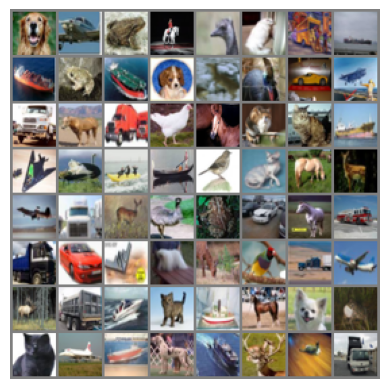

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = unnormalized_image_grid.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(trainloader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)


## Get class labels

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(classes[labels[0]])  


dog


# Baseline model

In [8]:
# Run this once to confirm shapes
xb, yb = next(iter(trainloader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]


Batch shape: torch.Size([64, 3, 32, 32])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# ===== Autoencoder, training loop, and visualization =====
from typing import Tuple
from torch import nn
import torch.optim as optim
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ConvAutoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Encoder: 32x32 -> 16x16 -> 8x8 (latent 128ch)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 3x32x32 -> 32x16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x16x16 -> 64x8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# 64x8x8 -> 128x8x8
            nn.ReLU(inplace=True),
        )
        # Decoder: 8x8 -> 16x16 -> 32x32, output in [-1, 1] via Tanh
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),      # 128x8x8 -> 64x8x8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),       # 64x8x8 -> 32x16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),        # 32x16x16 -> 3x32x32
            nn.Tanh(),  # because inputs are normalized to [-1, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def run_epoch(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer | None,
) -> Tuple[float, int]:
    """
    If optimizer is None -> eval mode; otherwise train mode.
    Returns (sum_loss, num_samples).
    """
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    n = 0

    for xb, _ in loader:  # labels are unused for autoencoders
        xb = xb.to(device, non_blocking=True)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        xhat = model(xb)
        loss = criterion(xhat, xb)  # reconstruct normalized input
        if is_train:
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss, n


# ---- Train ----
train_hist = []
val_hist = []
epochs = 10
best_val = float("inf")
for epoch in range(1, epochs + 1):
    train_loss_sum, train_n = run_epoch(model, trainloader, optimizer)
    val_loss_sum, val_n = run_epoch(model, validloader, optimizer=None)

    train_loss = train_loss_sum / train_n
    val_loss   = val_loss_sum / val_n

    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"Epoch {epoch:02d}/{epochs} | train MSE: {train_loss:.5f} | val MSE: {val_loss:.5f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "conv_autoencoder_cifar10.pt")
        print("  ↳ Saved new best model.")

Using device: cpu
Epoch 01/10 | train MSE: 0.02807 | val MSE: 0.01097
  ↳ Saved new best model.
Epoch 02/10 | train MSE: 0.00909 | val MSE: 0.00672
  ↳ Saved new best model.
Epoch 03/10 | train MSE: 0.00669 | val MSE: 0.00555
  ↳ Saved new best model.
Epoch 04/10 | train MSE: 0.00471 | val MSE: 0.00400
  ↳ Saved new best model.
Epoch 05/10 | train MSE: 0.00413 | val MSE: 0.00336
  ↳ Saved new best model.
Epoch 06/10 | train MSE: 0.00365 | val MSE: 0.00332
  ↳ Saved new best model.
Epoch 07/10 | train MSE: 0.00319 | val MSE: 0.00267
  ↳ Saved new best model.
Epoch 08/10 | train MSE: 0.00282 | val MSE: 0.00267
Epoch 09/10 | train MSE: 0.00266 | val MSE: 0.00223
  ↳ Saved new best model.
Epoch 10/10 | train MSE: 0.00244 | val MSE: 0.00222
  ↳ Saved new best model.


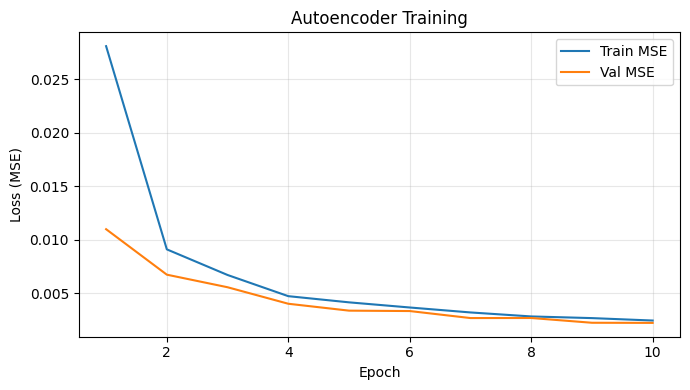

In [11]:
import matplotlib.pyplot as plt
import numpy as np

epochs_axis = np.arange(1, len(train_hist) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_hist, label="Train MSE")
plt.plot(epochs_axis, val_hist, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Training")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Originals:
Shape before transpose: (3, 138, 274)
Shape after transpose: (138, 274, 3)


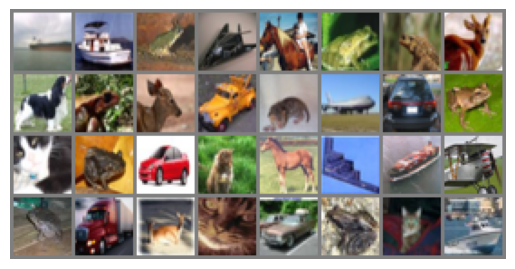

Reconstructions:
Shape before transpose: (3, 138, 274)
Shape after transpose: (138, 274, 3)


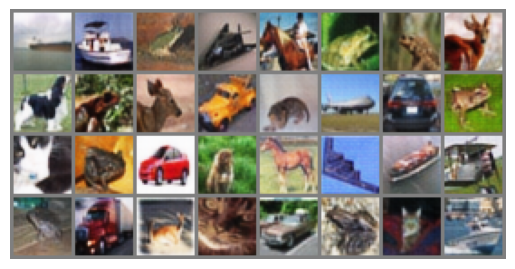

Test MSE: 0.00222


In [12]:
# ---- Quick reconstruction preview ----
model.eval()
with torch.inference_mode():
    xb, _ = next(iter(validloader))
    xb = xb.to(device)
    xhat = model(xb)
    # make grids for originals and reconstructions (same normalization [-1,1])
    grid_orig = torchvision.utils.make_grid(xb[:32].cpu(), nrow=8)   # 4 rows
    grid_reco = torchvision.utils.make_grid(xhat[:32].cpu(), nrow=8)
    print("Originals:")
    show_image(grid_orig)
    print("Reconstructions:")
    show_image(grid_reco)

# (Optional) compute a simple test MSE
test_loss_sum, test_n = run_epoch(model, testloader, optimizer=None)
print(f"Test MSE: {test_loss_sum / test_n:.5f}")

# Find outliers

# Sample from the latent distribution

# overlay with data points
What does it mean?

# Feature extraction 
From latent space

# Train classifier/regressor 
Using the latent space representation of the samples